In [1]:
import pandas as pd

# Upload the Excel file
from google.colab import files
uploaded = files.upload()

# Load the Excel file (replace with the filename you uploaded)
file_name = next(iter(uploaded))
df = pd.read_excel(file_name, engine='openpyxl')
df.head()

Saving model_extent.pkl to model_extent.pkl
Saving cleaned_rice_production_for_colab.xlsx to cleaned_rice_production_for_colab.xlsx
Saving model_yield.pkl to model_yield.pkl


BadZipFile: File is not a zip file

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode season and district
df['Season_encoded'] = LabelEncoder().fit_transform(df['Season'])
df['District_encoded'] = LabelEncoder().fit_transform(df['District'])

In [5]:
features = ['Year', 'Season_encoded', 'District_encoded',
            'Sown(hect)', 'Extent Harvested(hect)', 'Yield(kg per hect)']
target = 'Total production(mt.)'

# Drop rows with missing values
df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

In [12]:
!pip install lightgbm catboost

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = CatBoostRegressor(
    iterations=100000,       # high upper limit
    early_stopping_rounds=100,  # stop if no improvement for 100 rounds
    verbose=100,
    random_state=42
)

model.fit(X_train, y_train)

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 2160.792092684755
R² Score: 0.9928735279409663


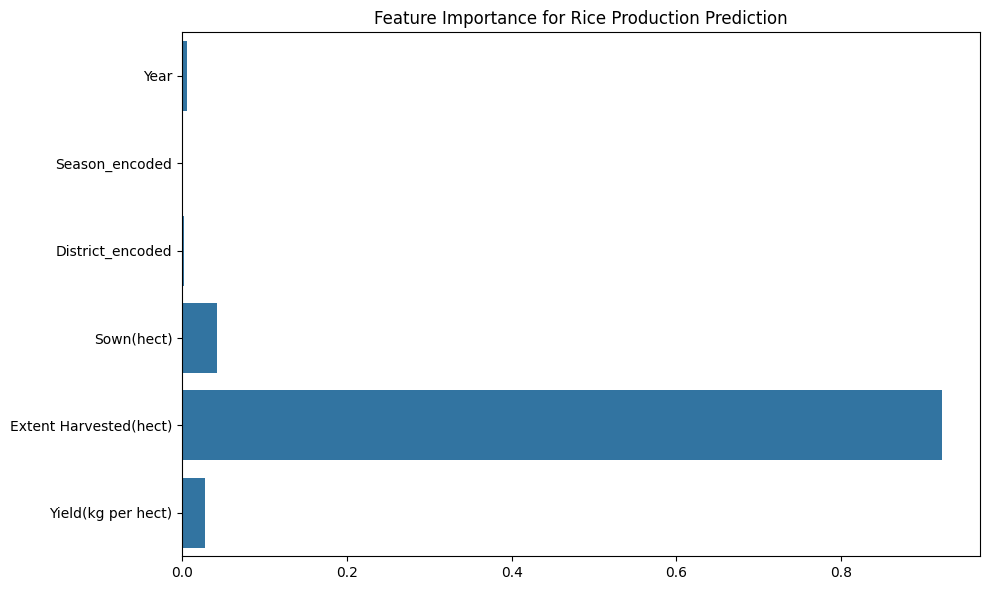

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance for Rice Production Prediction")
plt.tight_layout()
plt.show()

In [9]:
!pip install lightgbm catboost
import joblib

# Load the models from the uploaded files
model_extent = joblib.load("model_extent.pkl")
model_yield = joblib.load("model_yield.pkl")

# Example: predict rice production for 2025 Yala season in Polonnaruwa
example_input = pd.DataFrame([{
    'Year': 2023,
    'Season_encoded': 1,  # Assume 1 = Yala
    'District_encoded': df['District'].unique().tolist().index('COLOMBO'),
    'Sown(hect)': 2218
}])

prediction_extent = model_extent.predict(example_input)[0]
prediction_yield = model_yield.predict(example_input)[0]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00


In [11]:
# Example: predict rice production for 2025 Yala season in Polonnaruwa
example_f_input = pd.DataFrame([{
    'Year': 2023,
    'Season_encoded': 1,  # Assume 1 = Yala
    'District_encoded': df['District'].unique().tolist().index('COLOMBO'),
    'Sown(hect)': 2218,
    'Extent Harvested(hect)': prediction_extent,
    'Yield(kg per hect)': prediction_yield
}])

prediction = model.predict(example_f_input)[0]
print(f"🔮 Predicted Production for 2023 (COLOMBO - Yala): {int(prediction):,} metric tons")

🔮 Predicted Production for 2023 (COLOMBO - Yala): 8,175 metric tons
